# Model Training

## 1.1 Import Data and Required Packages

### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
!pip3 install catboost
!pip3 install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

## Import the CSV Data as Pandas DataFrame

In [3]:
df = pd.read_csv('supermarket_dataset.csv')

## Show Top 5 Records

In [4]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating,gross_margin,rating_bined,z_score
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,2023-05-17 13:08:00,Ewallet,522.83,4.761905,26.1415,9.1,0.047619,High,0.919147
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,2023-05-17 10:29:00,Cash,76.40,4.761905,3.8200,9.6,0.047619,High,-0.987236
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,2023-05-17 13:23:00,Credit card,324.31,4.761905,16.2155,7.4,0.047619,Medium,0.071410
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,2023-05-17 20:33:00,Ewallet,465.76,4.761905,23.2880,8.4,0.047619,High,0.675442
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,2023-05-17 10:37:00,Ewallet,604.17,4.761905,30.2085,5.3,0.047619,Low,1.266492


We want to understand the different types of customers and tailor our marketing and sales strategies accordingly, so we have to apply machine learning algorithms to the dataset. For example, we can use a clustering algorithm to group the customers into different segments based on their spending patterns and preferences

# K-Means

In [5]:
# using K-Means clustering algorithm to group the customers into three segment

# create a new DataFrame with only the relevant columns
df_clustering = df[['Customer type', 'Gender', 'Total']]

# apply one-hot encoding to the categorical columns
df_clustering = pd.get_dummies(df_clustering)

# initialize the K-Means model with 3 clusters
kmeans = KMeans(n_clusters=3)

# fit the model to the data
kmeans.fit(df_clustering)

# predict the clusters for each data point
predicted_clusters = kmeans.predict(df_clustering)

# add the predicted clusters as a new column to the DataFrame
df_clustering['Segment'] = predicted_clusters

# group the data by segment and calculate the averae total amount spent by each segment
df_segment_sales = df_clustering.groupby('Segment')['Total'].mean()
print(df_segment_sales)

Segment
0    132.628777
1    403.044149
2    759.660586
Name: Total, dtype: float64


Based on the result of the clustering is presented with three segment(0, 1, 2) and the number of customers in each segment, grouped by different customer type and genders.

Segment 0 has the highest mean spending per customer, with value of 759.66. We can suggest that customer in this segment are likely to be high spenders and may be interested in premium or luxury products. Segment 1 has the lowest mean spending per customer, with a value of 132.63, indicating that these customers are likely to be more price-sensitive and may be interested in values or budget products. Finally, segment 2 has a mederate mean spending per customer, with a value of 403.04, suggesting these customers may be interested in products that offer a balance between quality and affordabillity.

In [6]:
# group the data by segment and customer type
df_segment_type = df_clustering.groupby(['Segment', 'Customer type_Member', 'Customer type_Normal']).size()

print(df_segment_type)

Segment  Customer type_Member  Customer type_Normal
0        0                     1                       267
         1                     0                       252
1        0                     1                       150
         1                     0                       162
2        0                     1                        82
         1                     0                        87
dtype: int64


In [7]:
# group the data by segment and gender
df_segment_gender = df_clustering.groupby(['Segment', 'Gender_Male', 'Gender_Female']).size()

print(df_segment_gender)

Segment  Gender_Male  Gender_Female
0        0            1                247
         1            0                272
1        0            1                168
         1            0                144
2        0            1                 86
         1            0                 83
dtype: int64


Look at the customer type and gender we can see that, Segment 0 has rougly equal numbers of male and female customer, while Segment 1 has more female customers than male customers. This information could be useful in tailoring marketing and sales strategies to different segments.

For intance, promotions for luxury products could be targeted towards Segment 0, while promotions for budget products could be targeted towards Segment 1.

## Random Forest Classification

using random forest classification algorithm to predict the customer ratings based on the other features in the dataset. This can help us understand the facter that influence customer ratings and improve our services to increase customer stisfaction.

In [8]:
# create a new DataFrame with only the relevant colums
df_classification = df[['Customer type', 'Gender', 'Product line', 'Unit price','Quantity', 'Tax 5%', 'Total', 'Payment', 'cogs', 'gross margin percentage', 'gross income', 'Rating']]

# apply one-hot encoding to the categorical columns
df_classification = pd.get_dummies(df_classification)

# convert the numeric target variable into a categorical variable by binning the values in to 3 bins
df_classification['Rating'] = pd.cut(df_classification['Rating'], bins=3, labels=[1,2,3])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_classification.drop('Rating', axis=1), df_classification['Rating'], test_size = 0.2)

# initialize the Random Forest model
random_forest = RandomForestClassifier()

# fit the model to the traing data
random_forest.fit(X_train, y_train)

# predict the ratings for the test data
predicted_ratings = random_forest.predict(X_test)

# calculate the accuracy of the predictions
accuracy = random_forest.score(X_test, y_test)
print("Accuracy :", accuracy)

Accuracy : 0.34


The code uses Random Forest classification to predict customer ratings based on dataset features. It aims to understand factors influencing ratings and improve services for increased customer satisfaction. Relevant columns are selected and one-hot encoded. The numeric rating is transformed into a categorical variable. Data is split into training and testing sets. Random Forest classifier is trained and used for rating predictions. Accuracy is calculated and printed as 0.38, indicating alignment with actual ratings around 38.0% of the time.

### Mean absolute error

In [9]:
# calculate the mean absolute error between the predicted and actual rating
mae = mean_absolute_error(y_test, predicted_ratings)

print('Mean absolute error:', mae)

Mean absolute error: 0.88


A lower mean absolute error typically suggests more accurate predictions from the model, while a higher mean absolute error indicates less accuracy. In this case, a mean absolute error of 0.98 suggests that the model is making relatively accurate predictions.

### Mean Squared error

In [10]:
# calculate the mean squared error between the predicted and actual rating
mse = mean_squared_error(y_test, predicted_ratings)

print('Mean Squared Error', mse)

Mean Squared Error 1.32


A lower mean square error typically suggest more accurate predictions from model, while a higher mean square error indicates less accuracy. in this case. a mean square error of 1.45 suggest that model is making relatively accurate predictions.

### Root Mean Squared Error

In [11]:
# calculate root mean squared error between the predicted and actual rating
rmse = mean_squared_log_error(y_test, predicted_ratings)

print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 0.16089191716756424


A lower root mean squared error typically suggest more accurate predictions from model, while a higher root mean squared error indicates less accuracy. in this case. a root mean squared error of 0.17 suggest that model is making relatively accurate predictions.

## Predict the customer ratings for new data

In [12]:
# create a new DataFrame with only the relevant columns
df_new = df[['Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Payment', 'cogs', 'gross margin percentage', 'gross income']]

# apply one-hot encoding to the categorical columns
df_new = pd.get_dummies(df_new)

# predict the ratings for the new data
predicted_ratings = random_forest.predict(df_new)

# print the predicted ratings
print(predicted_ratings)

[3 3 2 3 1 1 1 2 2 1 1 2 1 3 1 1 1 2 3 1 1 1 1 3 2 3 2 3 3 2 1 1 1 1 2 2 2
 1 2 2 2 2 1 1 2 3 3 1 3 1 3 3 1 3 2 3 1 2 3 3 3 2 3 3 2 3 2 3 2 1 3 1 1 3
 3 1 3 1 2 2 1 2 3 3 2 1 3 2 2 2 2 1 1 3 2 2 1 1 3 2 1 2 1 1 2 2 3 2 2 3 1
 2 3 1 3 1 1 1 1 1 2 2 1 3 2 1 2 1 3 2 2 3 2 1 1 2 3 2 3 3 1 3 3 3 2 3 3 1
 3 1 2 2 2 3 1 3 2 1 1 1 3 1 2 2 3 1 1 3 2 2 1 3 2 3 3 3 3 1 1 1 2 2 2 1 2
 2 2 2 3 1 1 1 3 1 3 1 1 1 1 1 2 2 3 3 1 2 2 2 1 2 1 3 2 1 2 3 3 1 3 2 2 1
 1 3 2 3 1 3 1 2 2 3 3 2 2 1 1 3 1 1 3 1 1 1 3 1 1 2 3 1 2 2 2 1 3 2 3 3 2
 2 2 1 1 1 2 3 2 3 1 2 2 3 2 1 2 2 2 2 1 2 2 2 2 3 3 2 2 3 1 1 2 2 1 2 1 2
 2 3 1 2 2 1 1 1 3 1 3 1 1 2 1 3 1 1 1 1 2 2 3 3 1 3 2 2 3 2 1 3 1 3 2 3 1
 2 3 3 2 1 2 3 2 3 2 3 2 2 2 1 1 1 2 3 1 2 3 2 3 1 2 1 3 3 2 2 2 3 1 1 2 2
 3 1 1 3 3 2 3 1 3 1 3 1 3 1 2 1 2 3 3 2 3 2 2 2 2 1 1 3 3 2 3 2 3 3 1 2 2
 1 1 1 1 2 2 2 3 2 3 3 3 3 2 3 3 2 1 1 3 2 2 2 2 2 2 3 2 3 1 2 2 2 2 1 2 3
 3 3 3 2 1 3 2 2 1 1 1 2 3 2 1 2 2 3 2 2 3 2 2 2 1 3 1 2 1 1 2 2 1 2 1 2 3
 2 1 1 2 2 2 3 1 3 1 2 3 

Next, using regression algorithm to predict the total sales for each city based on the other attributes in the dataset.This can help us understand the factors that influence sales and improve our marketing and sales strategies to increase revenue. 

### preparing X and Y variables

In [13]:
# craete a new dataframe with only the relavant columns
X = df[['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Payment', 'cogs', 'gross margin percentage', 'gross income']]
X.head()

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Payment,cogs,gross margin percentage,gross income
0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,Ewallet,522.83,4.761905,26.1415
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,Cash,76.40,4.761905,3.8200
2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,Credit card,324.31,4.761905,16.2155
3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,Ewallet,465.76,4.761905,23.2880
4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,Ewallet,604.17,4.761905,30.2085


print out for check unique values of each categories column

In [14]:
print("Categories in 'Branch' variable: ", end=" ")
print(df['Branch'].unique())

print("Categories in 'City' variable: ", end=" ")
print(df['City'].unique())

print("Categories in 'Customer type' variable: ", end=" ")
print(df['Customer type'].unique())

print("Categories in 'Product line' variable: ", end=" ")
print(df['Product line'].unique())

print("Categories in 'Payment' variable: ", end=" ")
print(df['Payment'].unique())

Categories in 'Branch' variable:  ['A' 'C' 'B']
Categories in 'City' variable:  ['Yangon' 'Naypyitaw' 'Mandalay']
Categories in 'Customer type' variable:  ['Member' 'Normal']
Categories in 'Product line' variable:  ['Health and beauty' 'Electronic accessories' 'Home and lifestyle'
 'Sports and travel' 'Food and beverages' 'Fashion accessories']
Categories in 'Payment' variable:  ['Ewallet' 'Cash' 'Credit card']


In [15]:
y = df['Total']
y

0       548.9715
1        80.2200
2       340.5255
3       489.0480
4       634.3785
         ...    
995      42.3675
996    1022.4900
997      33.4320
998      69.1110
999     649.2990
Name: Total, Length: 1000, dtype: float64

In [16]:
# Create Column Transformer with 3 types of transformer

# selects columns from the DataFrame X based on their data type, it selects only the columns that contain numeric data.
num_feature = X.select_dtypes(exclude="object").columns

# selects columns from the DataFrame X based on their data type, it selects only the columns that contain categories data.
cat_feature = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_feature),
        ("StandardScaler", numeric_transformer, num_feature),
    ]
)

In [17]:
X = preprocessor.fit_transform(X)

In [18]:
X.shape

(1000, 25)

In [19]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((800, 25), (200, 25))

### creat an Evaluate Function to give all metrics after model Training

In [20]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_log_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [24]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.0131
- Mean Absolute Error: 0.8278
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0132
- Mean Absolute Error: 0.8714
- R2 Score: 1.0000


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.0064
- Mean Absolute Error: 0.2317
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0070
- Mean Absolute Error: 0.2206
- R2 Score: 1.0000


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.2298
- Mean Absolute Error: 26.1606
- R2 Score: 0.9816
----------------------

In [25]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=['R2_Score'], ascending=False)

,Model Name,R2_Score
0,Linear Regression,1.000000
2,Ridge,0.999999
1,Lasso,0.999983
5,Random Forest Regressor,0.999972
4,Decision Tree,0.999940
6,XGBRegressor,0.999845
7,CatBoosting Regressor,0.999720
8,AdaBoost Regressor,0.995934
3,K-Neighbors Regressor,0.973111


Text(0, 0.5, 'Predicted')

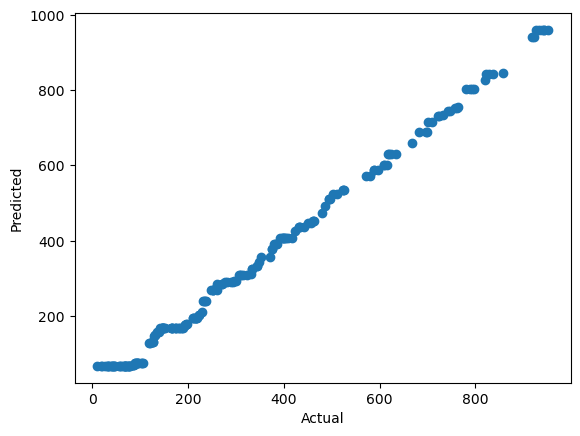

In [27]:
plt.scatter(y_test,y_test_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted')

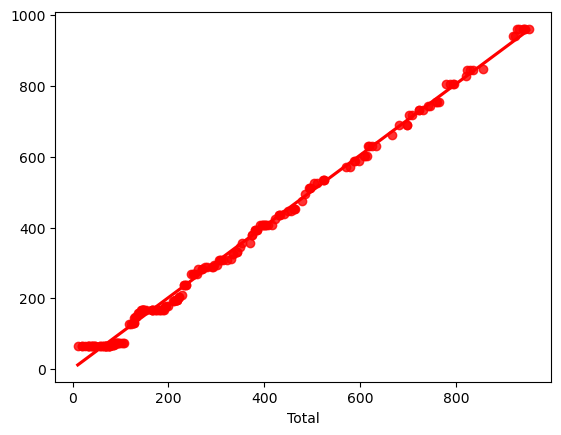

In [28]:
sns.regplot(x=y_test, y=y_test_pred, ci=None, color='red');

In [31]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_test_pred,'Difference':y_test-y_test_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,523.9710,535.514000,-11.543000
737,616.9800,630.304182,-13.324182
740,408.7335,407.101911,1.631589
660,135.3555,157.641876,-22.286376
411,45.9270,66.727601,-20.800601
...,...,...,...
408,237.4260,239.080897,-1.654897
332,404.3550,407.101911,-2.746911
208,95.6655,74.845938,20.819562
613,84.9765,69.060229,15.916271


In [37]:
df_regression = df[['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Payment', 'cogs', 'gross margin percentage', 'gross income']]
df_regression = pd.get_dummies(df_regression)

X_train, X_test, y_train, y_test = train_test_split(df_regression, df['Total'], test_size=0.2
                                                   )
rf = RandomForestRegressor()

rf.fit(X_train,y_train)

predicted_totals = rf.predict(X_test)

In [48]:
df_new = df[['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Payment', 'cogs', 'gross margin percentage', 'gross income']]

df_new = pd.get_dummies(df_new)

predicted_totals_new = rf.predict(df_new)

pred_totals_new = pd.DataFrame({'New Data Prediction':predicted_totals_new})
print(pred_totals_new)

     New Data Prediction
0             549.384990
1              80.505600
2             340.327890
3             488.954025
4             633.698625
..                   ...
995            42.092820
996          1024.199400
997            33.431580
998            69.151215
999           651.063420

[1000 rows x 1 columns]
